In [1]:
!pip install -q medmnist
!pip install -q xgboost scikit-learn matplotlib seaborn opencv-python albumentations scikit-image mahotas scipy imbalanced-learn umap-learn tensorflow pillow tqdm
!mkdir class_task

mkdir: cannot create directory ‘class_task’: File exists


In [2]:
import medmnist
from medmnist import INFO
from medmnist import PathMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import imagesize
from collections import defaultdict
import hashlib
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

In [3]:
# data will go to ~/.medmnist by default
train_dataset = PathMNIST(split='train', download=True, size=128)
val_dataset = PathMNIST(split='val', download=True, size=128)
test_dataset = PathMNIST(split='test', download=True, size=128)

!cp /root/.medmnist/pathmnist_224.npz /content/class_task/

100%|██████████| 4.26G/4.26G [07:53<00:00, 8.99MB/s]


cp: cannot stat '/root/.medmnist/pathmnist_224.npz': No such file or directory


In [4]:
# I will use my Google Drive as a persistent cache
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import shutil

shutil.copy('/root/.medmnist/pathmnist_128.npz', '/content/drive/MyDrive/aml_project/pathmnist_128.npz')

'/content/drive/MyDrive/aml_project/pathmnist_128.npz'

In [4]:
# Import the dataset from the drive
!mkdir -p /root/.medmnist
!cp /content/drive/MyDrive/aml_project/pathmnist_128.npz /root/.medmnist/pathmnist_128.npz
!cp /root/.medmnist/pathmnist_128.npz /content/class_task/

In [ ]:
train_dataset = PathMNIST(split='train', download=False, size=128)
val_dataset = PathMNIST(split='val', download=False, size=128)
test_dataset = PathMNIST(split='test', download=False, size=128)


Class distribution in train set:
Background                    : 9366 samples
Normal colon mucosa           : 9509 samples
Colon mucosa                  : 10360 samples
Colon submucosa               : 10401 samples
Lymphoid tissue               : 8006 samples
Debris                        : 12182 samples
Cancer-associated stroma      : 7886 samples
Tumor epithelium              : 9401 samples
Mucus                         : 12885 samples


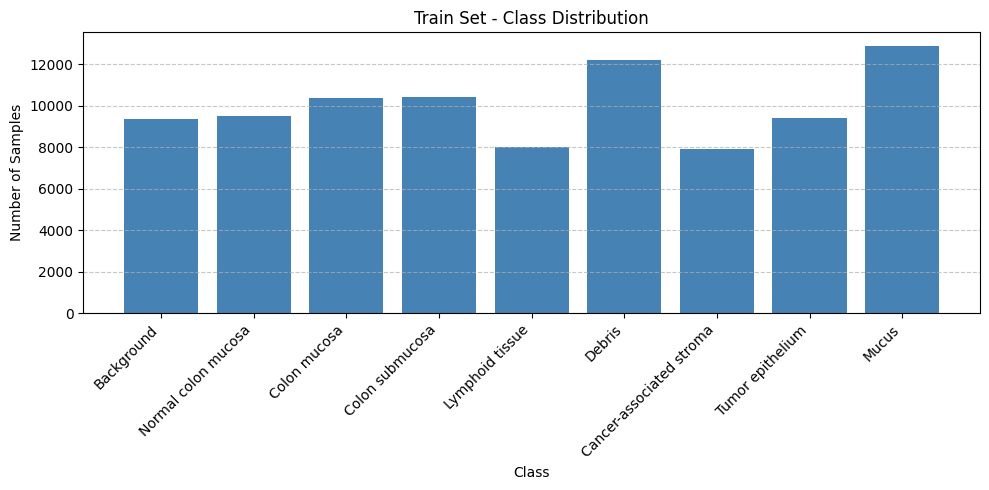


Class distribution in validation set:
Background                    : 1041 samples
Normal colon mucosa           : 1057 samples
Colon mucosa                  : 1152 samples
Colon submucosa               : 1156 samples
Lymphoid tissue               : 890 samples
Debris                        : 1354 samples
Cancer-associated stroma      : 877 samples
Tumor epithelium              : 1045 samples
Mucus                         : 1432 samples


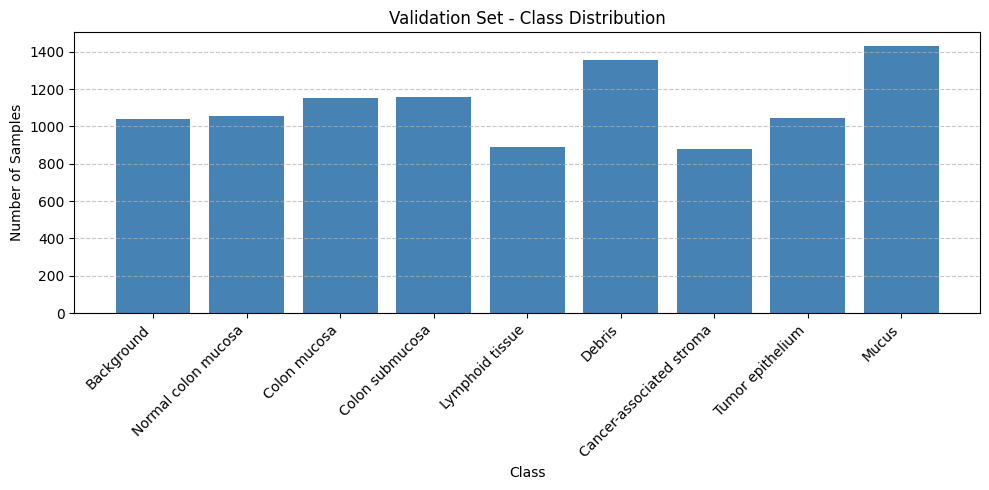


Class distribution in test set:
Background                    : 1338 samples
Normal colon mucosa           : 847 samples
Colon mucosa                  : 339 samples
Colon submucosa               : 634 samples
Lymphoid tissue               : 1035 samples
Debris                        : 592 samples
Cancer-associated stroma      : 741 samples
Tumor epithelium              : 421 samples
Mucus                         : 1233 samples


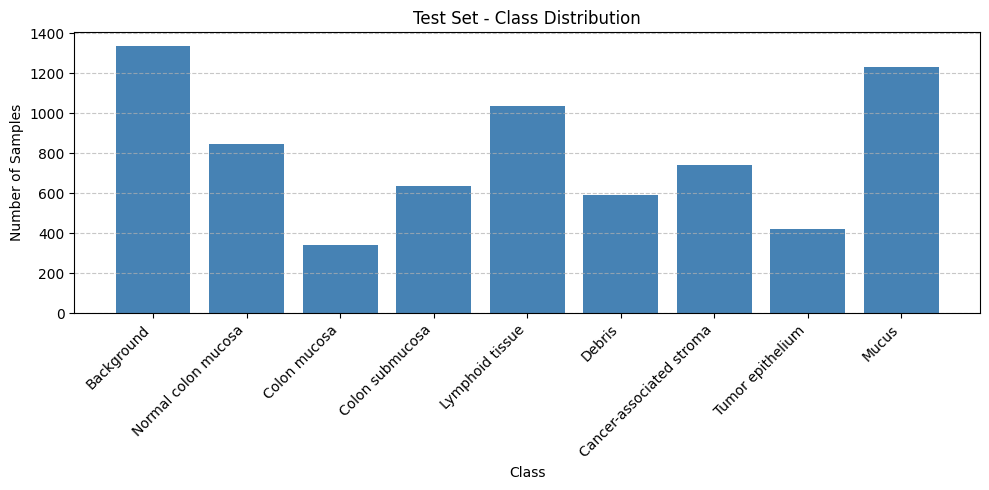

In [8]:
from collections import Counter

pathmnist_classes = {
    0: "Background",
    1: "Normal colon mucosa",
    2: "Colon mucosa",
    3: "Colon submucosa",
    4: "Lymphoid tissue",
    5: "Debris",
    6: "Cancer-associated stroma",
    7: "Tumor epithelium",
    8: "Mucus"
}

# Class distribution
def analyze_class_distribution(dataset, split_name):
    labels = dataset.labels.flatten()
    counts = Counter(labels)

    print(f"\nClass distribution in {split_name} set:")
    for cls_idx in range(9):
        class_name = pathmnist_classes[cls_idx]
        print(f"{class_name:30s}: {counts[cls_idx]} samples")

    class_names = [pathmnist_classes[i] for i in range(9)]
    class_counts = [counts[i] for i in range(9)]

    plt.figure(figsize=(10, 5))
    bars = plt.bar(class_names, class_counts, color='steelblue')
    plt.title(f"{split_name.capitalize()} Set - Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

analyze_class_distribution(train_dataset, "train")
analyze_class_distribution(val_dataset, "validation")
analyze_class_distribution(test_dataset, "test")


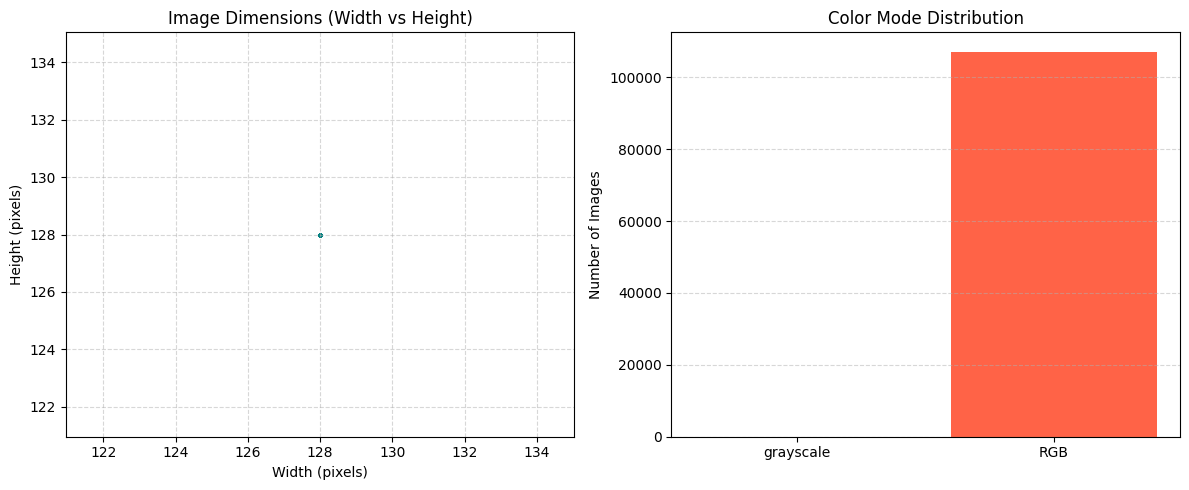

In [7]:
all_images = np.concatenate([train_dataset.imgs, val_dataset.imgs, test_dataset.imgs], axis=0)  # shape: (N, H, W, C)

heights = [img.shape[0] for img in all_images]
widths  = [img.shape[1] for img in all_images]

color_modes = {"grayscale": 0, "RGB": 0}
for img in all_images:
    if img.shape[-1] == 1:
        color_modes["grayscale"] += 1
    elif img.shape[-1] == 3:
        color_modes["RGB"] += 1

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Image Dimensions
axes[0].scatter(widths, heights, alpha=0.3, color="teal", s=2)
axes[0].set_title("Image Dimensions (Width vs Height)")
axes[0].set_xlabel("Width (pixels)")
axes[0].set_ylabel("Height (pixels)")
axes[0].grid(True, linestyle="--", alpha=0.5)

# Color Mode Distribution
axes[1].bar(color_modes.keys(), color_modes.values(), color=['gray', 'tomato'])
axes[1].set_title("Color Mode Distribution")
axes[1].set_ylabel("Number of Images")
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [3]:
from sklearn.model_selection import train_test_split
from pathlib import Path
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import random
from skimage import io, img_as_ubyte
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.measure import shannon_entropy
from skimage.filters import sobel, gabor
from skimage.color import rgb2gray
import mahotas
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler, label_binarize
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
import umap
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.tree import DecisionTreeClassifier
from torch.utils.data import Dataset
import torch


AUGMENTATION_THRESHOLD = 0.5
MAX_AUGMENTATION_FACTOR = 6
TRAIN_SIZE = 0.6
VAL_SIZE = 0.20
TEST_SIZE = 0.20
RANDOM_STATE = 42

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

In [4]:
train_dataset = PathMNIST(split='train', download=False, size=128)

In [5]:
augmentation = A.Compose([
    A.SomeOf([
                            A.RandomRotate90(p=0.5),
                            A.HorizontalFlip(p=0.5),
                            A.OneOf([
                                A.GaussNoise(p=0.3),
                                A.GaussianBlur(blur_limit=(1, 3), p=0.3),
                            ], p=0.3),
                            A.Affine(scale=(0.9, 1.1),
                                     translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
                                     rotate=(-20, 20),
                                     shear={"x": 0, "y": 0}, p=0.5),
                            A.OneOf([
                                A.OpticalDistortion(p=0.2),
                                A.GridDistortion(num_steps=5, distort_limit=0.05, p=0.2),
                            ], p=0.2),
                            A.OneOf([
                                A.CLAHE(clip_limit=2, tile_grid_size=(4, 4), p=0.5),
                                A.RandomBrightnessContrast(p=0.3),
                                A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3),
                            ], p=0.4)
        ], n=4, p=1.0)
])

In [6]:
def apply_augmentation(images, labels, target_per_class, augmentation):
    class BalancedDataset(Dataset):
        def __init__(self, images, labels, target_per_class, augmentation):
            self.images = []
            self.labels = []
            self.augmentation = augmentation
            self.num_classes = len(np.unique(labels))

            for cls in range(self.num_classes):
                idx = np.where(labels == cls)[0]
                cls_imgs = images[idx]
                cls_count = len(cls_imgs)
                needed = target_per_class - cls_count

                # Original images (converted to tensors)
                self.images.extend([ToTensorV2()(image=img)['image'] for img in cls_imgs])
                self.labels.extend([cls] * cls_count)

                # Augment if needed
                if needed > 0:
                    for _ in range(needed):
                        img = random.choice(cls_imgs)
                        aug = augmentation(image=img)
                        self.images.append(aug['image'])
                        self.labels.append(cls)

            self.labels = torch.tensor(self.labels)

        def __len__(self):
            return len(self.labels)

        def __getitem__(self, idx):
            return self.images[idx], self.labels[idx]

    return BalancedDataset(images, labels, target_per_class, augmentation)

In [7]:
X = train_dataset.imgs
y = train_dataset.labels.squeeze()

target = 12000
augmented_train_dataset = apply_augmentation(X, y, target, augmentation)

In [9]:
analyze_class_distribution(augmented_train_dataset, "train")

Class distribution (after balancing):
Class 0: 12000
Class 1: 12000
Class 2: 12000
Class 3: 12000
Class 4: 12000
Class 5: 12182
Class 6: 12000
Class 7: 12000
Class 8: 12885


In [ ]:
train_loader = DataLoader(balanced_dataset, batch_size=32, shuffle=True)